In [1]:
%matplotlib inline
import random
# random.seed(0)
import mlrose
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
warnings.simplefilter('ignore')
import pandas as pd
from util import init_weights, compute_loss, perturb_weights, plot_loss
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

In [2]:
# Load data
data_white = pd.read_csv('data/winequality-white.csv', delimiter=';')
data_red = pd.read_csv('data/winequality-red.csv', delimiter=';')
data_white["type"] = 0
data_red["type"] = 1

In [3]:
data = data_white.append(data_red, ignore_index=True)
data = data.dropna()

X, y = data.drop('quality', axis=1), data.quality
y = (y<6).astype(int)
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [4]:
kf = KFold(n_splits=5)
acc_tr = {}
time_tr = {}
acc_val = {}
acc_te = {}

def evaluate(algo_name, param_name, clf, kf):
    
    if algo_name not in acc_tr:
        acc_tr[algo_name] = {}
        acc_te[algo_name] = {}
        acc_val[algo_name] = {}
        time_tr[algo_name] = {}
    if param_name not in acc_tr[algo_name]:
        acc_tr[algo_name][param_name] = []
        acc_te[algo_name][param_name] = []
        acc_val[algo_name][param_name] = []
        time_tr[algo_name][param_name] = []
    eval_time = []
    eval_tr = []
    eval_te = []
    eval_val = []
    
    for train_index, val_index in kf.split(X_train):
        x_tr, x_val = X_train, X_train#X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train, y_train#y_train[train_index], y_train[val_index]
        
        time_start = datetime.now()
        clf.fit(x_tr, y_tr)
        eval_time.append((datetime.now() - time_start).microseconds)
        
        y_train_pred = clf.predict(x_tr)
        y_val_pred = clf.predict(x_val)
        y_train_accuracy = accuracy_score(y_tr, y_train_pred)
        y_val_accuracy = accuracy_score(y_val, y_val_pred)
        eval_tr.append(y_train_accuracy)    
        eval_val.append(y_val_accuracy)
#         if algo_name=='ga':
        break
        
        
    eval_time = np.array(eval_time).mean() / 1000
    eval_tr = np.array(eval_tr).mean()
    eval_val = np.array(eval_val).mean()

    y_test_pred = clf.predict(X_test)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    
    acc_tr[algo_name][param_name].append(eval_tr)
    acc_val[algo_name][param_name].append(eval_val)
    acc_te[algo_name][param_name].append(y_test_accuracy)    
    time_tr[algo_name][param_name].append(eval_time)
    return eval_val

## Gradient descent

In [5]:
iteration_range = range(500, 3001, 750)

best_val_score = -1
best_clf = ""
for it in iteration_range:
    print("Eval iter", it)

    algo = 'gd'
    clf = mlrose.NeuralNetwork(hidden_nodes=[10,3], activation='relu', algorithm='gradient_descent',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    score = evaluate(algo, 'iter', clf, kf)
    if best_val_score<score:
        best_val_score = score
        best_clf = clf

Eval iter 500
Eval iter 1250
Eval iter 2000
Eval iter 2750


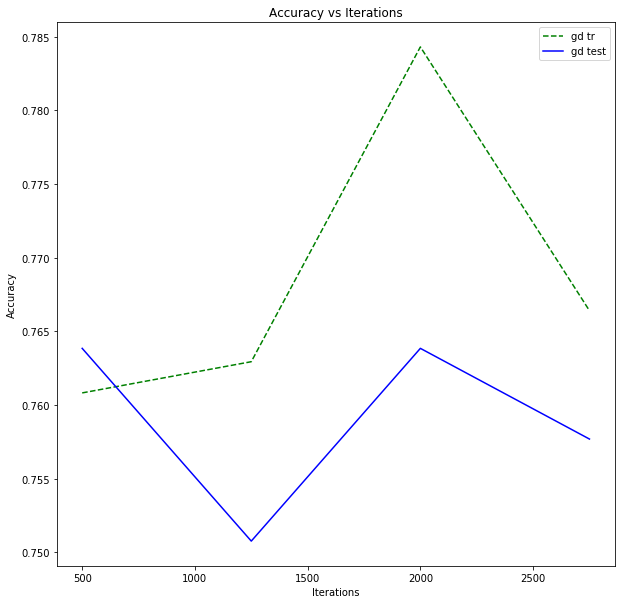

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_tr['gd']['iter'], label='gd tr', linestyle='--', color='g')
# plt.plot(iteration_range, acc_te['gd']['iter'], label='gd val', linestyle='-', color='b')
plt.plot(iteration_range, acc_te['gd']['iter'], label='gd test', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [7]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       850
           1       0.67      0.63      0.65       450

   micro avg       0.76      0.76      0.76      1300
   macro avg       0.74      0.73      0.73      1300
weighted avg       0.76      0.76      0.76      1300



## GA

In [8]:
iteration_range = range(500, 2001, 500)

best_val_score = -1
best_clf = ""
for it in iteration_range:
    print("Eval iter", it)

    algo = 'ga'
    clf = mlrose.NeuralNetwork(hidden_nodes=[10,3], activation='relu', algorithm='genetic_alg',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    score = evaluate(algo, 'iter', clf, kf)
    if best_val_score<score:
        best_val_score = score
        best_clf = clf

Eval iter 500
Eval iter 1000
Eval iter 1500
Eval iter 2000


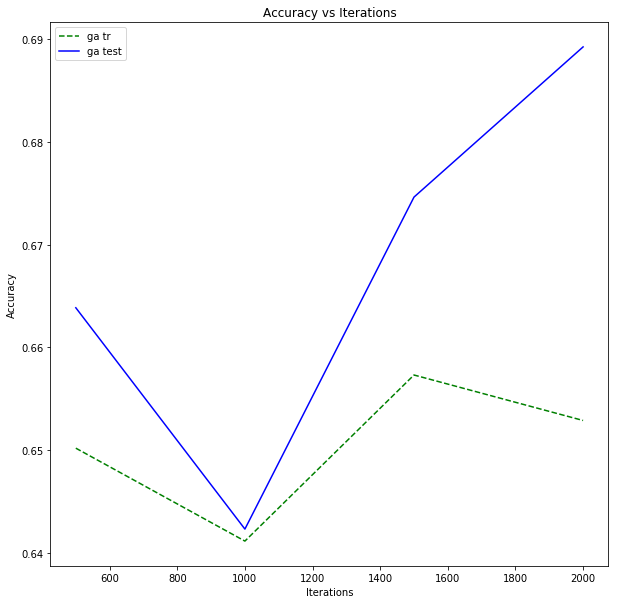

In [9]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_tr['ga']['iter'], label='ga tr', linestyle='--', color='g')
plt.plot(iteration_range, acc_te['ga']['iter'], label='ga test', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [10]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79       850
           1       0.60      0.18      0.27       450

   micro avg       0.67      0.67      0.67      1300
   macro avg       0.64      0.56      0.53      1300
weighted avg       0.66      0.67      0.61      1300



## Training time

In [11]:
print("Training time for GD in seconds")
print(np.mean(time_tr['gd']['iter'])/1000.0)

Training time for GD in seconds
0.59826825


In [13]:
print("Training time for GA in seconds")
print(np.mean(time_tr['ga']['iter'])/1000.0)

Training time for GA in seconds
703.50425
